## Question 2

In [91]:
# Question 2

# Loading in the MNIST package and fetching the data
from mnist import MNIST
mndata = MNIST('C:/Users/mishr/Downloads')
train = mndata.load_training()
test = mndata.load_testing()

print(type(train))
print(len(train[0]), len(train[1])) # Train is a tuple with two arrays of 60000 length
# The first array is the array of images, second is the array of labels
print(len(test[0]), len(test[1]))

# Each element of the images array is already flattened i.e. it is a vector of 784 elements (28 x 28).
# We can change this later on.


# To load the images in 28 x 28 format:
# from keras.datasets import mnist
# (x_train, _), (x_test, _) = mnist.load_data()

<class 'tuple'>
60000 60000
10000 10000


In [192]:
# Creating the modified training and testing datasets

import numpy as np
import pandas as pd

# We need to create duplicate images from train and test with some noise.
# For each image in train, we will create two images.

# Converting train to a pandas dataframe 
train_data = pd.DataFrame(train[0])

train_data = train_data.append(train_data)

# Creating the new datasets
np.random.seed(123)
mask1 = np.random.rand(120000,784) # Creating a mask of the same dimensions as train
mask1 = mask1 > 0.03 # Gives true where the random value is > 0.03. We will change False values.

# Making the noise datasets
train_noise = train_data.where(mask1, other = 255 - train_data)

# Doing a sense check of pixels changed
check = ((train_noise == train_data) * 1).sum().sum() # Gives us the number of trues
total = 120000*784
print("The proportion of pixels changed in train noise are: ", (total - check)/total)

train_noise = train_noise.as_matrix()

# Normalizing the pixels
train_data = train_data.astype("float32")/255
train_noise = train_noise.astype("float32")/255


# Doing the same for test but for test, we will generate only one changed image per image

# Converting test to a pandas dataframe 
test_data = pd.DataFrame(test[0])

np.random.seed(246)
mask1 = np.random.rand(10000,784) # Creating a mask of the same dimensions as train
mask1 = mask1 > 0.03 # Gives us a true value where the random value is > 0.03.

# Making the noise datasets
test_noise = test_data.where(mask1, other = 255 - test_data)

# Doing a sense check of pixels changed
check = ((test_noise == test_data) * 1).sum().sum() # Gives us the number of trues
total = 10000*784
print("The proportion of pixels changed in test noise are: ", (total - check)/total)

test_noise = test_noise.as_matrix()

# Normalizing the pixels
test_noise = test_noise.astype("float32")/255
test_data = test_data.astype("float32")/255

The proportion of pixels changed in train noise are:  0.030032057823129253
The proportion of pixels changed in test noise are:  0.029999362244897958


In [193]:
# Changing dataset shapes
train_data = np.reshape(train_data.as_matrix(), (len(train_data), 28, 28, 1))
test_data = np.reshape(test_data.as_matrix(), (len(test_data), 28, 28, 1))

train_noise = np.reshape(train_noise, (len(train_noise), 28, 28, 1))
print("Shape of the noisy train dataset is: ", train_noise.shape)

test_noise = np.reshape(test_noise, (len(test_noise), 28, 28, 1))
print("Shape of the noisy test dataset is: ", test_noise.shape)

Shape of the noisy train dataset is:  (120000, 28, 28, 1)
Shape of the noisy test dataset is:  (10000, 28, 28, 1)


In [2]:
# Creating the Convolutional NN in Keras

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import TensorBoard

# Usually we work with Keras using the sequential model where we add layers
# This way is also similar. We are making layers without explicitly defining the model object

input_img = Input(shape=(28, 28, 1)) # Shape of each input image to the CNN

# 32 is the number of convolutional filters and 3x3 is the shape of the filter. A different choice of
# numbers in the convolutional filter leads to a different result and helps us recognize different
# features in the image.
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)

# MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 
# pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

# The same model object defined above - but we add more layers to it
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# Now we will create the decoder layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Finally, the full model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ["mse"])


Using TensorFlow backend.


In [3]:
encoded.summary()

AttributeError: 'Tensor' object has no attribute 'summary'

In [160]:
# Looking at each step of the autoencoder
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [195]:
# We will train the model on a sample of the images

sample_mask = np.random.choice(120000, 12000, replace = False)
train_sample = train_data[sample_mask,:,:]
train_noise_s = train_noise[sample_mask,:,:]

fit1 = autoencoder.fit(train_noise_s, train_sample,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_noise, test_data),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 105s - loss: 0.2960 - mean_squared_error: 0.0758 - val_loss: 0.1691 - val_mean_squared_error: 0.0358
Epoch 2/10
12000/12000 [==============================] - 107s - loss: 0.1351 - mean_squared_error: 0.0242 - val_loss: 0.1220 - val_mean_squared_error: 0.0199
Epoch 3/10
12000/12000 [==============================] - 106s - loss: 0.1159 - mean_squared_error: 0.0178 - val_loss: 0.1066 - val_mean_squared_error: 0.0147
Epoch 4/10
12000/12000 [==============================] - 110s - loss: 0.1062 - mean_squared_error: 0.0145 - val_loss: 0.1021 - val_mean_squared_error: 0.0134
Epoch 5/10
12000/12000 [==============================] - 103s - loss: 0.1005 - mean_squared_error: 0.0127 - val_loss: 0.0960 - val_mean_squared_error: 0.0113
Epoch 6/10
12000/12000 [==============================] - 102s - loss: 0.0963 - mean_squared_error: 0.0113 - val_loss: 0.0934 - val_mean_squared_error: 0.0

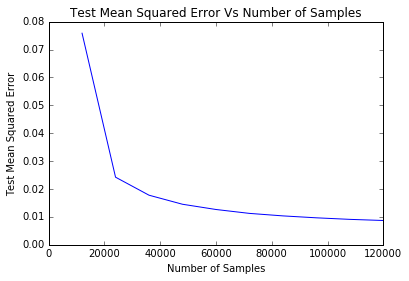

In [202]:
model1_rmse = fit1.history["mean_squared_error"]
samples_no = np.arange(1, 11) * (12000)

plt.plot(samples_no, model1_rmse)
plt.xlabel("Number of Samples")
plt.ylabel("Test Mean Squared Error")
plt.title("Test Mean Squared Error Vs Number of Samples")

In [198]:
# Predictions on test set
test_decoded = autoencoder.predict(test_noise)

# L2 error for each image
l2_error = np.linalg.norm(test_data - test_decoded, axis = (2, 3))
l2_error = np.linalg.norm(l2_error, axis = 1)

print("l2_error shape: ", l2_error.shape)

# Getting the indices of the best and worst error
sorted_indices = np.argsort(l2_error)

best_images = sorted_indices[:10]
worst_images = sorted_indices[-10:]

l2_error shape:  (10000,)


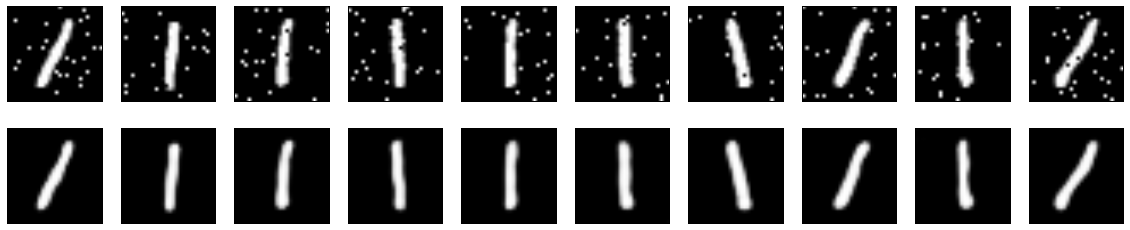

In [199]:
# Plotting the best images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(best_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

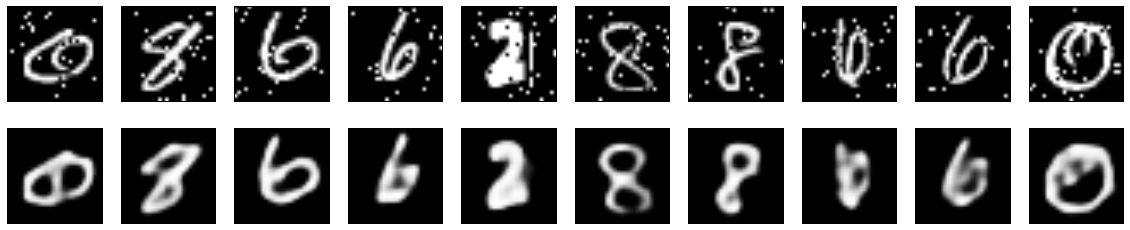

In [200]:
# Plotting the worst images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(worst_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [207]:
# Implementing 3 changes in the CNN architeture

# Change 1 - changing the optimizer to adam
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["mse"])

In [208]:
# We will train the model on a sample of the images

fit1 = autoencoder.fit(train_noise_s, train_sample,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_noise, test_data),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 104s - loss: 0.2405 - mean_squared_error: 0.0573 - val_loss: 0.1169 - val_mean_squared_error: 0.0182
Epoch 2/10
12000/12000 [==============================] - 103s - loss: 0.1037 - mean_squared_error: 0.0138 - val_loss: 0.0940 - val_mean_squared_error: 0.0106
Epoch 3/10
12000/12000 [==============================] - 103s - loss: 0.0913 - mean_squared_error: 0.0097 - val_loss: 0.0871 - val_mean_squared_error: 0.0085
Epoch 4/10
12000/12000 [==============================] - 102s - loss: 0.0862 - mean_squared_error: 0.0081 - val_loss: 0.0841 - val_mean_squared_error: 0.0075
Epoch 5/10
12000/12000 [==============================] - 103s - loss: 0.0832 - mean_squared_error: 0.0072 - val_loss: 0.0811 - val_mean_squared_error: 0.0066
Epoch 6/10
12000/12000 [==============================] - 103s - loss: 0.0811 - mean_squared_error: 0.0065 - val_loss: 0.0794 - val_mean_squared_error: 0.0

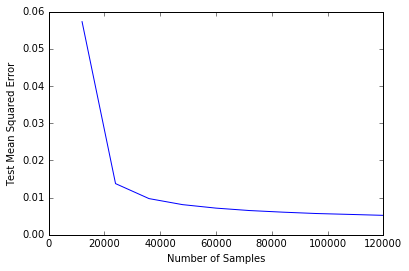

In [209]:
model1_rmse = fit1.history["mean_squared_error"]
samples_no = np.arange(1, 11) * (12000)

plt.plot(samples_no, model1_rmse)
plt.xlabel("Number of Samples")
plt.ylabel("Test Mean Squared Error")


In [210]:
# Predictions on test set
test_decoded = autoencoder.predict(test_noise)

# L2 error for each image
l2_error = np.linalg.norm(test_data - test_decoded, axis = (2, 3))
l2_error = np.linalg.norm(l2_error, axis = 1)

print("l2_error shape: ", l2_error.shape)

# Getting the indices of the best and worst error
sorted_indices = np.argsort(l2_error)

best_images = sorted_indices[:10]
worst_images = sorted_indices[-10:]

l2_error shape:  (10000,)


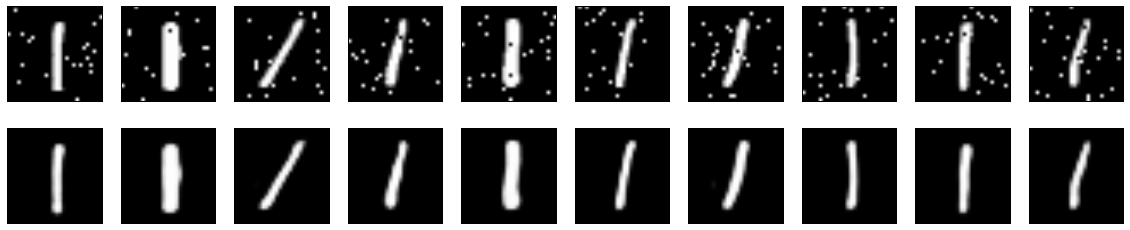

In [211]:
# Plotting the best images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(best_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

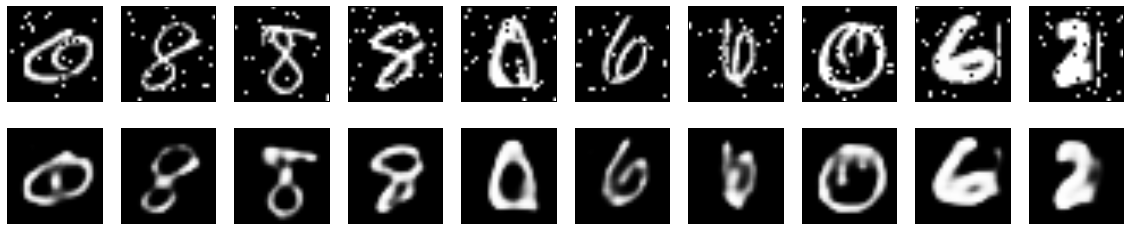

In [212]:
# Plotting the worst images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(worst_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [214]:
# Change 2 - changing the loss function to mean squared error

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics = ["mse"])

In [215]:
# We will train the model on a sample of the images

fit1 = autoencoder.fit(train_noise_s, train_sample,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_noise, test_data),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 108s - loss: 0.0937 - mean_squared_error: 0.0937 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 2/10
12000/12000 [==============================] - 104s - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 3/10
12000/12000 [==============================] - 101s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 4/10
12000/12000 [==============================] - 103s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 5/10
12000/12000 [==============================] - 103s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 6/10
12000/12000 [==============================] - 104s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0122 - val_mean_squared_error: 0.0

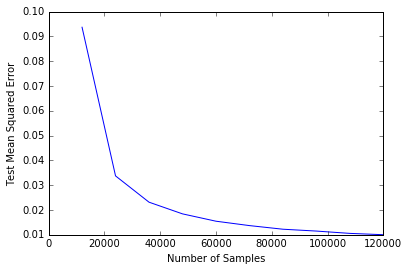

In [217]:
model1_rmse = fit1.history["mean_squared_error"]
samples_no = np.arange(1, 11) * (12000)

plt.plot(samples_no, model1_rmse)
plt.xlabel("Number of Samples")
plt.ylabel("Test Mean Squared Error")


In [218]:
# Predictions on test set
test_decoded = autoencoder.predict(test_noise)

# L2 error for each image
l2_error = np.linalg.norm(test_data - test_decoded, axis = (2, 3))
l2_error = np.linalg.norm(l2_error, axis = 1)

print("l2_error shape: ", l2_error.shape)

# Getting the indices of the best and worst error
sorted_indices = np.argsort(l2_error)

best_images = sorted_indices[:10]
worst_images = sorted_indices[-10:]

l2_error shape:  (10000,)


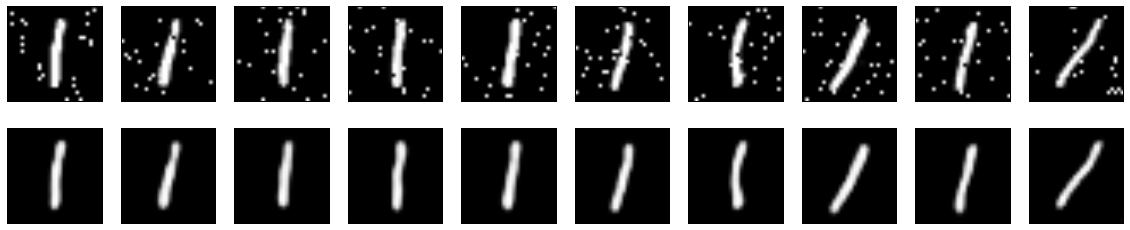

In [219]:
# Plotting the best images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(best_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

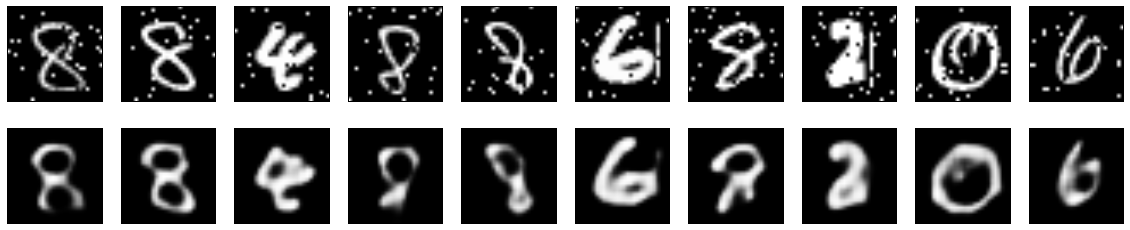

In [220]:
# Plotting the worst images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(worst_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [221]:
# Change 3 - changing the number of filters and size of all filters to 5x5
input_img = Input(shape=(28, 28, 1))

x = Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(64, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ["mse"])

In [222]:
# We will train the model on a sample of the images

fit1 = autoencoder.fit(train_noise_s, train_sample,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_noise, test_data),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 12000 samples, validate on 10000 samples
Epoch 1/10
12000/12000 [==============================] - 395s - loss: 0.2599 - mean_squared_error: 0.0637 - val_loss: 0.1588 - val_mean_squared_error: 0.0319
Epoch 2/10
12000/12000 [==============================] - 415s - loss: 0.1361 - mean_squared_error: 0.0243 - val_loss: 0.1180 - val_mean_squared_error: 0.0182
Epoch 3/10
12000/12000 [==============================] - 487s - loss: 0.1133 - mean_squared_error: 0.0167 - val_loss: 0.1229 - val_mean_squared_error: 0.0204
Epoch 4/10
12000/12000 [==============================] - 481s - loss: 0.1048 - mean_squared_error: 0.0139 - val_loss: 0.0994 - val_mean_squared_error: 0.0120
Epoch 5/10
12000/12000 [==============================] - 390s - loss: 0.0981 - mean_squared_error: 0.0118 - val_loss: 0.0969 - val_mean_squared_error: 0.0117
Epoch 6/10
12000/12000 [==============================] - 381s - loss: 0.0944 - mean_squared_error: 0.0106 - val_loss: 0.1055 - val_mean_squared_error: 0.0

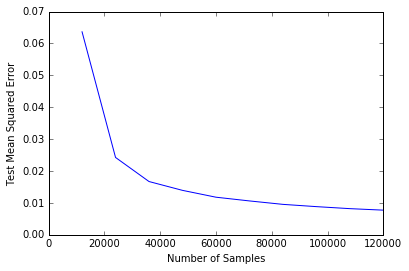

In [223]:
model1_rmse = fit1.history["mean_squared_error"]
samples_no = np.arange(1, 11) * (12000)

plt.plot(samples_no, model1_rmse)
plt.xlabel("Number of Samples")
plt.ylabel("Test Mean Squared Error")


In [224]:
# Predictions on test set
test_decoded = autoencoder.predict(test_noise)

# L2 error for each image
l2_error = np.linalg.norm(test_data - test_decoded, axis = (2, 3))
l2_error = np.linalg.norm(l2_error, axis = 1)

print("l2_error shape: ", l2_error.shape)

# Getting the indices of the best and worst error
sorted_indices = np.argsort(l2_error)

best_images = sorted_indices[:10]
worst_images = sorted_indices[-10:]

l2_error shape:  (10000,)


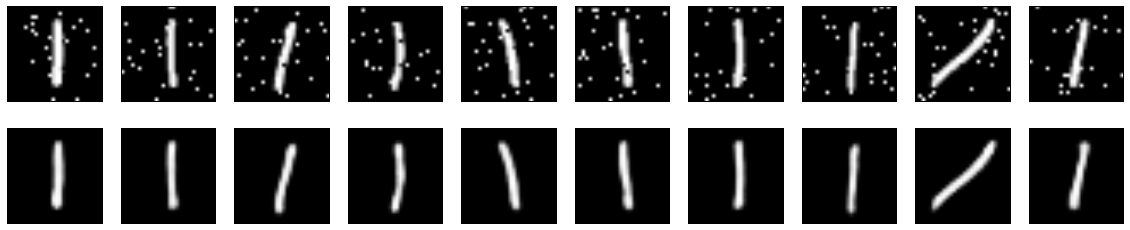

In [225]:
# Plotting the best images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(best_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

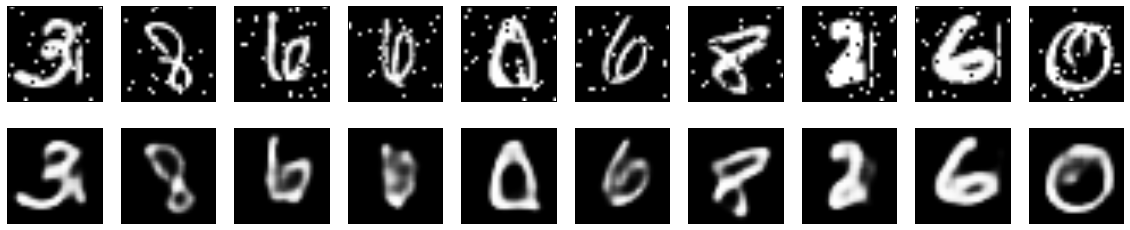

In [226]:
# Plotting the worst images
n = 10
plt.figure(figsize=(20, 4))
for i,j in zip(worst_images, list(range(1,n+1))):
    # display original
    ax = plt.subplot(2, n, j)
    plt.imshow(test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### All of our auto-encoders are giving the best results on the digit 1. This result makes the best sense as the digit 1 is the easiest to identify and also harder to confuse with other digits.
### On the other hand, digits like 6, 8 and 0 which have loops in them are the easiest to confuse with each other. This is why our autoencoder is not performing well on them. Also, there are many ways to write those digits and it varies from person to person.

### Modification 1: Using Adam instead of Adagrad - Adam is a more complex way of updating the learning rate compared to Adagrad. It uses first order moment and second order moment. This is probably why Adam performed better than Adagrad. Although it is not always guaranteed to be better in every case.

### Modification 2: For the loss function, we used mean squared error instead of binary crossentropy. It is usual for the cross entropy loss to perform better in case the activation function in the output layer is a sigmoid or softmax. MSE is best in case we are doing regression. Thus the results we see are consistent with this observation and the mse results are poorer compared to the entropy results.

### Modification 3: For the last change, we changed the number of filters in the convolutional layers and the size of the convolution. More the number of filters, more will be the learning of the convolution layer. Thus this modification is expected to increase the performance of the model. The size of the convolution can result in either better performance or worse as it modifies more pixels in one go but is also run over the dataset less number of times. In our case, it performs better.